In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")
torch.cuda.empty_cache()

# Using device: cuda


In [ ]:
class dehazer():
    def __init__(self, IMG_SIZE, LABEL_DIR, LABEL_NAME):
        self.IMG_SIZE = IMG_SIZE
        self.LABEL_DIR = LABEL_DIR
        self.LABEL_NAME = LABEL_NAME
        self.training_data = []

    def make_training_data(self, batch_size=32):
        image_files = os.listdir(self.LABEL_DIR)
        NUM_IMAGES = len(image_files)

        for i in tqdm(range(0, NUM_IMAGES, batch_size)):
            batch_files = image_files[i:i+batch_size]
            batch_images = []

            for file_name in batch_files:
                if file_name.endswith('.png'):
                    path = os.path.join(self.LABEL_DIR, file_name)
                    img = cv2.imread(path)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    batch_images.append(img)

            self.training_data.extend(batch_images)

        np.save(f'{self.LABEL_NAME}.npy', np.array(self.training_data))

In [ ]:
REBUILD_DATA=True

IMG_SIZE=256
gt_dir='/content/drive/MyDrive/Dense_Haze_NTIRE19/GT'
hazy_dir='/content/drive/MyDrive/Dense_Haze_NTIRE19/hazy'

if (REBUILD_DATA):
    dehazing=dehazer(IMG_SIZE, gt_dir, 'GT')
    dehazing.make_training_data()

    dehazing=dehazer(IMG_SIZE, hazy_dir, 'hazy')
    dehazing.make_training_data()


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


In [ ]:
patch = np.load('GT.npy',allow_pickle=True)
mask = np.load('hazy.npy',allow_pickle=True)

len(patch), len(mask)

(55, 55)

In [ ]:
IMG_SIZE = 256

EPOCHS = 500
batch_size = 1
learning_rate = 0.0005

In [ ]:
patch_loader = torch.utils.data.DataLoader(dataset=patch,batch_size=1,shuffle=False)

for data in patch_loader:
    print(data.size())
    print(type(data))
    break

torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [ ]:
X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

X_orig=X_orig/255
X_hazy=X_hazy/255

print(X_orig.shape)

torch.Size([55, 256, 256, 3])


In [ ]:
# Assuming you already have X_orig and X_hazy

# Transpose the arrays
X_orig_T = np.transpose(X_orig, (0, 3, 1, 2))
X_hazy_T = np.transpose(X_hazy, (0, 3, 1, 2))

# Reshape the arrays
X_orig_flat = X_orig_T.reshape(-1, 1, X_orig_T.shape[2], X_orig_T.shape[3])
X_hazy_flat = X_hazy_T.reshape(-1, 1, X_hazy_T.shape[2], X_hazy_T.shape[3])

# Print the shapes
print('X_orig_T shape:', X_orig_T.shape)
print('X_orig_flat shape:', X_orig_flat.shape)

X_orig:  torch.Size([55, 256, 256, 3])
X_orig_T:  torch.Size([55, 3, 256, 256])
X_orig_flat:  torch.Size([165, 1, 256, 256])


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),   # batch x 32 x 256 x 256 , single channel , 32 feature maps, 3*3 kernel size
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),   # batch x 32 x 256 x 256
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),  # batch x 64 x 256 x 256
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),  # batch x 64 x 256 x 256
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)   # batch x 64 x 128 x 128 (max pooling reducing dimension by 2 times)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # batch x 128 x 128 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),  # batch x 128 x 128 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),  # batch x 256 x 64 x 64
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Use out.size(0) to get the batch size dynamically
        return out

encoder = Encoder().cuda()

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ConvTranspose2d(128, 128, 3, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ConvTranspose2d(128, 64, 3, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ConvTranspose2d(64, 64, 3, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(64)  # Batch normalization
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ConvTranspose2d(32, 32, 3, 1, 1),  # Transpose convolution layer
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1),  # Transpose convolution layer
            nn.ReLU()  # ReLU activation
        )

    def forward(self, x, batch_size):
        out = x.view(batch_size, 256, 64, 64)  # Reshape the input (assuming it's (batch_size, 256, 64, 64))
        out = self.layer1(out)  # Pass through the first set of layers
        out = self.layer2(out)  # Pass through the second set of layers
        return out



decoder = Decoder().cuda()  # Initialize the decoder

In [ ]:
train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


In [ ]:
# Create a combined parameter list for both encoder and decoder

parameters = list(encoder.parameters()) + list(decoder.parameters())

# Define the loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# Initialize an empty list to store losses during training
losses = []

# Create a copy of X_orig for later use
X_orig1 = X_orig

# Training loop
for epoch in tqdm(range(EPOCHS)):
    # Shuffle the data for each epoch
    rand_idx = torch.randperm(X_orig1.size()[0])
    X_orig_iter = X_orig[rand_idx]
    X_hazy_iter = X_hazy[rand_idx]

    # Transpose and reshape the data
    X_orig_iter1 = np.transpose(X_orig_iter, (0, 3, 1, 2))
    X_hazy_iter1 = np.transpose(X_hazy_iter, (0, 3, 1, 2))

    X_orig_iter2 = X_orig_iter1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
    X_hazy_iter2 = X_hazy_iter1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)

    # Create DataLoader instances for the current data
    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter2, batch_size=batch_size, shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter2, batch_size=batch_size, shuffle=False)

    # Training loop for the current epoch
    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()

        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)

        loss = loss_func(output, orig_image)
        loss.backward()
        optimizer.step()

    # Append the loss for the current epoch to the list
    losses.append(loss)
torch.save([encoder,decoder],'dehaze_autoencoder.pkl')

In [ ]:
encoder, decoder = torch.load('dehaze_autoencoder.pkl')


In [ ]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)


In [ ]:
dehazed_output=[]
cnt=0
for train_hazy in tqdm(train_hazy_loader):
    cnt+=1
    hazy_image = Variable(train_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)
print(cnt)

100%|██████████| 165/165 [00:01<00:00, 107.24it/s]

165


In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([165, 1, 1, 256, 256])
torch.Size([165, 1, 256, 256])
torch.Size([55, 3, 256, 256])
torch.Size([55, 256, 256, 3])


55


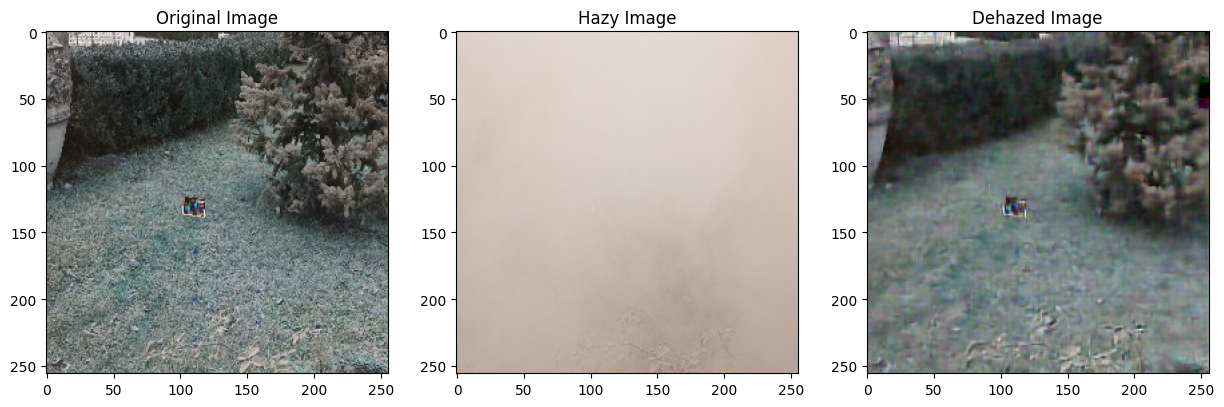

In [ ]:
print(len(X_orig))
for i in range(0,len(X_orig)):
    if(i==45):
      fig=plt.figure(figsize=(15, 5))
      ax = plt.subplot(131)
      plt.title('Original Image')
      plt.imshow(X_orig[i])

      ax = plt.subplot(132)
      plt.title('Hazy Image')
      plt.imshow(X_hazy[i])

      ax = plt.subplot(133)
      plt.title('Dehazed Image')
      plt.imshow(X_dehazed[i])
      plt.show()


In [ ]:
import cv2
import numpy as np
import torch

# Load and preprocess the image
img = cv2.imread("fog2.jpg")
img = cv2.resize(img, (256, 256))
img = np.array(img)

img = np.array([img])

print(img.shape)


img = np.transpose(img,(0,3,1,2))
print(img.shape)
img=img.reshape(-1,1,256,256)  # Convert to grayscale
print(img.shape)
img = img / 255.0  # Normalize the grayscale image



print(img.shape)

# Transfer the tensor to the GPU if available
if torch.cuda.is_available():
    img = torch.FloatTensor(img).cuda()

# Now you can use the img tensor for further processing
# For example, if you have an encoder-decoder model:



train_hazy_loader = torch.utils.data.DataLoader(dataset=img,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)


(1, 256, 256, 3)
(1, 3, 256, 256)
(3, 1, 256, 256)
(3, 1, 256, 256)


100%|██████████| 3/3 [00:00<00:00, 72.10it/s]


In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([3, 1, 1, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 256, 3])
